In [1]:
import sys
import numpy as np
import numpy as np
import torch
from torch import nn, distributions
from scipy.spatial.distance import cdist
from scipy.stats import norm
import matplotlib.pyplot as plt
from dataloader import DataLoader, SLDataset, sl_collate, make_relative_meters

torch.set_default_tensor_type(torch.FloatTensor)

In [24]:
def squared_exponential_kernel(x, y, lengthscale, variance):
    # pair-wise distances, size: NxM
    sqdist = cdist(x.reshape((-1, 1)), y.reshape((-1, 1)), 'sqeuclidean')
    # compute the kernel
    cov_matrix = variance * np.exp(-0.5 * sqdist * (1/lengthscale**2))  # NxM
    return cov_matrix

def fit_predictive_GP(X, y, Xtest, lengthscale, kernel_variance, noise_variance):

    X = np.array(X).reshape(-1, 1)
    y = np.array(y)
    K = squared_exponential_kernel(X, X, lengthscale, kernel_variance)
    L = np.linalg.cholesky(K + noise_variance * np.eye(len(X)))

    # compute the mean at our test points.
    Ks = squared_exponential_kernel(X, Xtest, lengthscale, kernel_variance)
    alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))  #
    mu = Ks.T @ alpha

    v = np.linalg.solve(L, Ks)
    # compute the variance at our test points.
    Kss = squared_exponential_kernel(Xtest, Xtest, lengthscale, kernel_variance)
    covariance = Kss - (v.T @ v)
    return mu, covariance


def optimize_GP_hyperparams(Xtrain, ytrain, optimization_steps, learning_rate, mean_prior, prior_std):
    
    def squared_exponential_kernel_torch(x, y, _lambda, variance):
        x = x.squeeze(1).expand(x.size(0), y.size(0))
        y = y.squeeze(0).expand(x.size(0), y.size(0))
        sqdist = torch.pow(x - y, 2)
        k = variance * torch.exp(-0.5 * sqdist * (1/_lambda**2))  # NxM
        return k

    def abs_kernel_torch(x, y, _lambda, variance):
        x = x.squeeze(1).expand(x.size(0), y.size(0))
        y = y.squeeze(0).expand(x.size(0), y.size(0))
        absdist = torch.abs(x - y)
        k = variance * torch.exp(-0.5 * absdist * (1/_lambda**2))  # NxM
        return k
    
    def rational_quadratic_kernel(x, y, _lambda, _alpha, variance):
        x = x.squeeze(1).expand(x.size(0), y.size(0))
        y = y.squeeze(0).expand(x.size(0), y.size(0))
        absdist = torch.abs(x - y)
        k = torch.pow(variance, 2) * torch.pow((1 + (1/(2*_alpha*_lambda**2)) * absdist),-_alpha)  # NxM
        return k
    
    def matern52_kernel_torch(x, y, _lambda, variance):
        x = x.squeeze(1).expand(x.size(0), y.size(0))
        y = y.squeeze(0).expand(x.size(0), y.size(0))
        sqdist = torch.pow(x - y, 2)
        k = torch.pow(variance, 2) * (1+torch.sqrt(5*sqdist)/_lambda + (5*sqdist)/(3*_lambda**2)) * torch.exp(-(torch.sqrt(5 * sqdist)/_lambda))  # NxM
        return k
    
    X = np.array(Xtrain).reshape(-1,1)
    y = np.array(ytrain).reshape(-1,1)
    N = len(X)

    # tranform our training set in Tensor
    Xtrain_tensor = torch.from_numpy(X).float()
    ytrain_tensor = torch.from_numpy(y).float()
    # we should define our hyperparameters as torch parameters where we keep track of
    # the operations to get hte gradients from them
    _lambda = nn.Parameter(torch.tensor(5.), requires_grad=True)
    _alphaP = nn.Parameter(torch.tensor(1.), requires_grad=True)
    output_variance = nn.Parameter(torch.tensor(1.), requires_grad=True)
    noise_variance = nn.Parameter(torch.tensor(.5), requires_grad=True)
    mu = nn.Parameter(torch.tensor(1.5), requires_grad=True)
    sig = nn.Parameter(torch.tensor(1.5), requires_grad=True)
    
    # we use Adam as optimizer
    optim = torch.optim.Adam([_lambda, output_variance, noise_variance, mu, sig, _alphaP], lr=learning_rate)

    # optimization loop using the log-likelihood that involves the cholesky decomposition 
    nlls = []
    lambdas = []
    output_variances = []
    noise_variances = []
    iterations = optimization_steps
    for i in range(iterations):
        assert noise_variance >= 0, f"ouch! {i, noise_variance}"
        optim.zero_grad()
        #K = rational_quadratic_kernel(Xtrain_tensor, Xtrain_tensor, _lambda, _alphaP,
        #                                        output_variance) + noise_variance * torch.eye(N)
        K = abs_kernel_torch(Xtrain_tensor, Xtrain_tensor, _lambda,
                                               output_variance) + noise_variance * torch.eye(N)
    
        L = torch.cholesky(K)
        _alpha_temp, _ = torch.solve(ytrain_tensor, L)
        _alpha, _ = torch.solve(_alpha_temp, L.t())

        nll = N / 2 * torch.log(torch.tensor(2 * np.pi)) + 0.5 * torch.matmul(ytrain_tensor.transpose(0, 1),
                                                                              _alpha) + torch.sum(torch.log(torch.diag(L)))

        # we have to add the log-likelihood of the prior
        norm = distributions.Normal(loc=mu, scale=sig)
        prior_negloglike =  torch.log(_lambda) - torch.log(torch.exp(norm.log_prob(_lambda)))

        nll += 0.9 * prior_negloglike
        nll.backward()

        nlls.append(nll.item())
        lambdas.append(_lambda.item())
        output_variances.append(output_variance.item())
        noise_variances.append(noise_variance.item())
        optim.step()

        # projected in the constraints (lengthscale and output variance should be positive)
        for p in [_lambda, output_variance]:
            p.data.clamp_(min=0.0000001)

        noise_variance.data.clamp_(min=1e-5, max= 0.05)
        
        mu.data.clamp_(min=-5, max= 5)
        sig.data.clamp_(min=0.5, max = 5)

        
    return _lambda.item(), output_variance.item(), noise_variance.item(), mu.item(), sig.item()

In [3]:
sln=40
dataset = SLDataset(csv_file='sep2018.csv', seq_len=sln, resample_freq='20s')
dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=0, collate_fn=sl_collate)

c:\users\jobe\documents\git\phd\courses\atiml\env\lib\site-packages\numpy\lib\function_base.py:1535: RuntimeWarning: invalid value encountered in remainder
  ddmod = mod(dd + pi, 2*pi) - pi


In [4]:
seq = next(iter(dataloader))

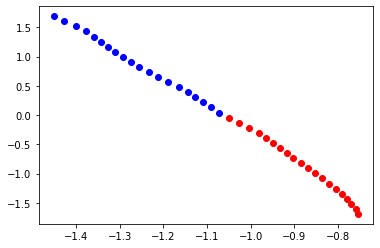

In [18]:
x = np.array(seq)
x_n = np.array(x)[:, np.where(np.array(x)[-1, :, 1] != -1)].squeeze().reshape(sln, -1, 4)
x = np.array(x_n)[:, np.where(np.array(x_n)[0, :, 1] != -1)].squeeze().reshape(sln, -1, 4)
xt, yt = make_relative_meters(x)
xt = np.flip(xt)
xt = (xt - np.mean(xt)) / np.std(xt)
yt = np.flip(yt)
yt = (yt - np.mean(yt)) / np.std(yt)

time = np.array(range(sln))
time = (time - np.mean(time)) / np.std(time)
split = int(sln * 0.5)
tx = time[:split]
ty = time[split:]

k=0

xx = xt[:split]
xy = yt[:split]
yx = xt[split:,k]
yy = yt[split:,k]
Xtrain = xx[:,k]
ytrain = xy[:,k]


#plt.plot(time, ytrain,'ro')
#plt.plot((40 + time),yy[:,0],'bo')
plt.plot(Xtrain, tx 	,'ro')
plt.plot(yx, ty,'bo')
plt.show()

mi: -1.689277519114419, ma: 1.689277519114419
Optimized parameters: ls: 5.570403575897217, ov: 0.15027080476284027, nv: 9.999999747378752e-06, mu: 2.3516082763671875, sig: 2.2142889499664307


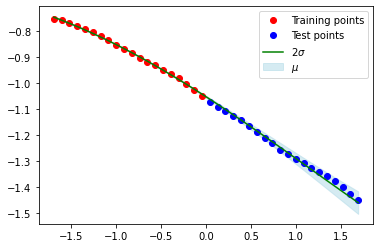

mi: -1.689277519114419, ma: 1.689277519114419
Optimized parameters: ls: 4.222954273223877, ov: 1.6502916812896729, nv: 9.999999747378752e-06, mu: 2.283205509185791, sig: 1.9974428415298462


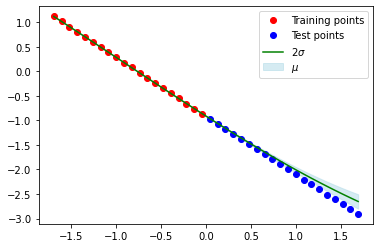

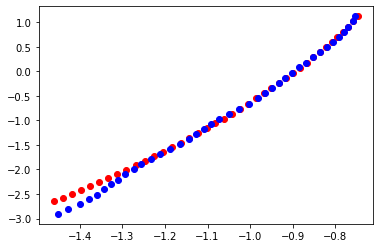

In [26]:
def fitGaussian(dXtrain, dytrain, dyx, dyy, draw=False):
    
    # print dataset information
    # also in this case we standardize the data to have zero mean and unit variance
    #dXtrain = (dXtrain - np.mean(dXtrain)) / np.std(dXtrain)
    #dyx = (dyx - np.mean(dXtrain)) / np.std(dXtrain)
    #dytrain = (dytrain - np.mean(dytrain)) / np.std(dytrain)
    #dyy = (dyy - np.mean(dytrain)) / np.std(dytrain)
    # and plot it
    #plt.plot(dXtrain, dytrain, 'o', color='black')
    #plt.ylabel('coord')
    #plt.xlabel('Time')
    #plt.show()

    # we shall also define the test set, that is the range of XTest points we want to 
    # use to compute the mean and the variance
    ma = max([max(dXtrain), max(dyx)])
    mi = min([min(dXtrain), min(dyx)]) 	
    print('mi: {}, ma: {}'.format(mi,ma))
    Xtest = np.linspace(mi, ma, sln).reshape(-1,1)
    ## we have to define the mean and variance of the log-normal distribution for the lengthscale prior 
    prior_mean = 1
    prior_std = 0.4

    lengthscale, output_var, noise_var, muu, sig = optimize_GP_hyperparams(dXtrain, dytrain, 100, 1e-2, prior_mean, prior_std)
    print('Optimized parameters: ls: {}, ov: {}, nv: {}, mu: {}, sig: {}'.format(lengthscale, output_var, noise_var, muu, sig))

    # we can fit the GP that use the hyperparameters found above
    mu, covariance = fit_predictive_GP(dXtrain, dytrain, Xtest, lengthscale, output_var, noise_var)
    std = np.sqrt(np.diag(covariance))
    if draw:
        plt.plot(dXtrain, dytrain, 'ro', label='Training points')
        plt.plot(dyx, dyy, 'bo', label='Test points')
        plt.gca().fill_between(Xtest.flat, mu.reshape(-1) - 2 * std, mu.reshape(-1) + 2 * std,  color='lightblue', alpha=0.5, label=r"$\mu$")
        plt.plot(Xtest, mu, 'green', label=r"$2\sigma$")
        plt.legend()
        plt.show()
    return mu, std


x_p,x_std = fitGaussian(tx, Xtrain, ty, yx, True)
y_p,y_std = fitGaussian(tx, ytrain, ty, yy, True)

plt.plot(x_p, y_p, 'ro', label='Training points')
plt.plot(Xtrain,ytrain,'bo')
plt.plot(yx,yy,'bo')
plt.show()

mi: -1.689277519114419, ma: 1.689277519114419
Optimized parameters: ls: 5.433368682861328, ov: 0.36994999647140503, nv: 9.999999747378752e-06, mu: 2.346006155014038, sig: 2.199310064315796
mi: -1.689277519114419, ma: 1.689277519114419
Optimized parameters: ls: 4.361010551452637, ov: 1.5005446672439575, nv: 9.999999747378752e-06, mu: 2.2896463871002197, sig: 2.0131185054779053


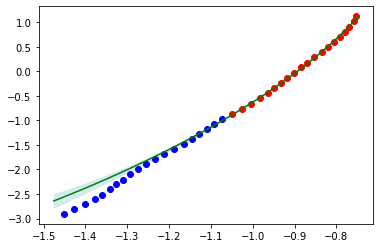

mi: -1.516018286384735, ma: 1.689277519114419
Optimized parameters: ls: 5.404178142547607, ov: 0.389235258102417, nv: 9.999999747378752e-06, mu: 2.344866991043091, sig: 2.1960175037384033
mi: -1.516018286384735, ma: 1.689277519114419
Optimized parameters: ls: 4.3620524406433105, ov: 1.4988123178482056, nv: 9.999999747378752e-06, mu: 2.289699077606201, sig: 2.013260841369629


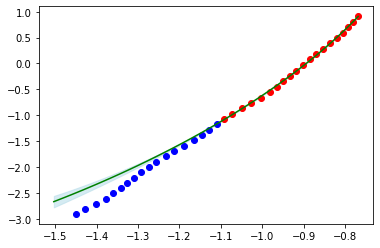

mi: -1.3427590536550509, ma: 1.689277519114419
Optimized parameters: ls: 5.3949360847473145, ov: 0.40120095014572144, nv: 9.999999747378752e-06, mu: 2.3443734645843506, sig: 2.1945080757141113
mi: -1.3427590536550509, ma: 1.689277519114419
Optimized parameters: ls: 4.3615241050720215, ov: 1.5003966093063354, nv: 9.999999747378752e-06, mu: 2.289663791656494, sig: 2.013150930404663


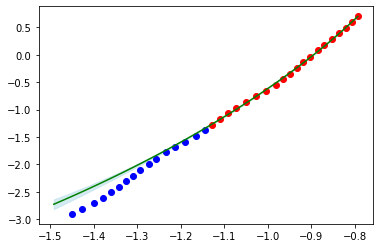

mi: -1.1694998209253669, ma: 1.689277519114419
Optimized parameters: ls: 5.394485950469971, ov: 0.4109766483306885, nv: 9.999999747378752e-06, mu: 2.344165086746216, sig: 2.1937930583953857
mi: -1.1694998209253669, ma: 1.689277519114419
Optimized parameters: ls: 4.364323616027832, ov: 1.4981637001037598, nv: 9.999999747378752e-06, mu: 2.2898004055023193, sig: 2.013524055480957


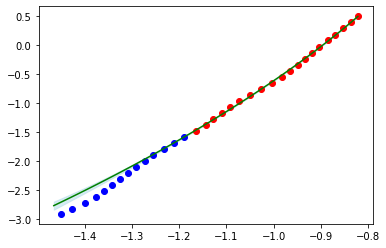

mi: -0.996240588195683, ma: 1.689277519114419
Optimized parameters: ls: 5.382917404174805, ov: 0.4269321858882904, nv: 9.999999747378752e-06, mu: 2.343514919281006, sig: 2.19181752204895
mi: -0.996240588195683, ma: 1.689277519114419
Optimized parameters: ls: 4.364560604095459, ov: 1.5005557537078857, nv: 9.999999747378752e-06, mu: 2.2897963523864746, sig: 2.0134921073913574


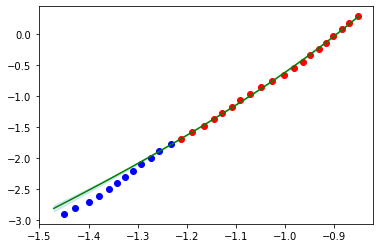

mi: -0.8229813554659989, ma: 1.689277519114419
Optimized parameters: ls: 5.377033710479736, ov: 0.4403079152107239, nv: 9.999999747378752e-06, mu: 2.3430733680725098, sig: 2.1904027462005615
mi: -0.8229813554659989, ma: 1.689277519114419
Optimized parameters: ls: 4.363349914550781, ov: 1.505647897720337, nv: 9.999999747378752e-06, mu: 2.289705753326416, sig: 2.013204574584961


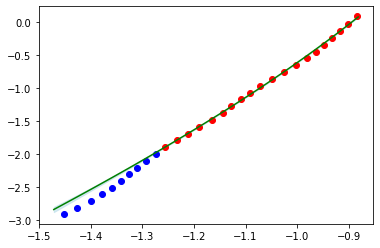

mi: -0.6497221227363149, ma: 1.689277519114419
Optimized parameters: ls: 5.3870015144348145, ov: 0.44731053709983826, nv: 9.999999747378752e-06, mu: 2.3432397842407227, sig: 2.1907050609588623
mi: -0.6497221227363149, ma: 1.689277519114419
Optimized parameters: ls: 4.3698344230651855, ov: 1.5015506744384766, nv: 9.999999747378752e-06, mu: 2.2900185585021973, sig: 2.0140469074249268


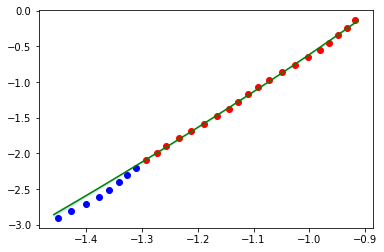

mi: -0.47646289000663095, ma: 1.689277519114419
Optimized parameters: ls: 5.398500919342041, ov: 0.45332634449005127, nv: 9.999999747378752e-06, mu: 2.343491792678833, sig: 2.1912996768951416
mi: -0.47646289000663095, ma: 1.689277519114419
Optimized parameters: ls: 4.372079372406006, ov: 1.5039547681808472, nv: 9.999999747378752e-06, mu: 2.2901058197021484, sig: 2.0142643451690674


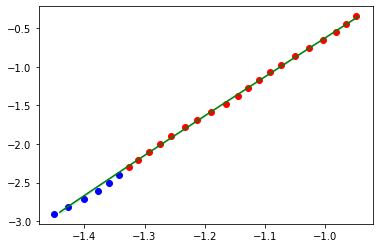

mi: -0.303203657276947, ma: 1.689277519114419
Optimized parameters: ls: 5.422550201416016, ov: 0.4604536294937134, nv: 9.999999747378752e-06, mu: 2.3445229530334473, sig: 2.194277763366699
mi: -0.303203657276947, ma: 1.689277519114419
Optimized parameters: ls: 4.372751235961914, ov: 1.5091557502746582, nv: 9.999999747378752e-06, mu: 2.290104866027832, sig: 2.014224052429199


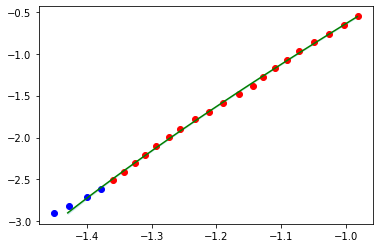

mi: -0.129944424547263, ma: 1.689277519114419
Optimized parameters: ls: 5.448017120361328, ov: 0.46393367648124695, nv: 9.999999747378752e-06, mu: 2.345231771469116, sig: 2.1962099075317383
mi: -0.129944424547263, ma: 1.689277519114419
Optimized parameters: ls: 4.37661075592041, ov: 1.511096715927124, nv: 9.999999747378752e-06, mu: 2.2902655601501465, sig: 2.0146307945251465


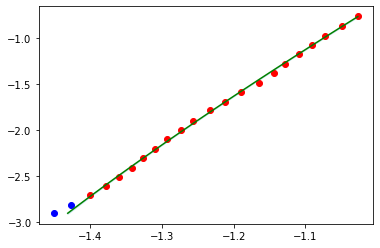

In [10]:
start = 0
split = int(sln * 0.5)

for x in range(10):
    inp_t = time[start:split]
    tar_t = time[split:]

    inp_x = xt[start:split,0]
    inp_y = yt[start:split,0]
    
    tar_x = xt[split:,0]
    tar_y = yt[split:,0]
    
    x_p, x_std = fitGaussian(inp_t, inp_x, tar_t, tar_x)
    y_p, y_std = fitGaussian(inp_t, inp_y, tar_t, tar_y)
  
    plt.plot(inp_x, inp_y,'ro')
    plt.plot(tar_x, tar_y,'bo')
    plt.plot(x_p, y_p, 'green', label='Training points')
    plt.gca().fill_between(x_p, y_p.reshape(-1) - 2 * y_std, y_p.reshape(-1) + 2 * y_std,  color='lightblue', alpha=0.5, label=r"$\mu$")
    
    start+=2
    split+=2
    plt.show()
